# Knot Lensing

## Lensing a Gaussian and comparing by eye to the observed knot

### RELICS WHL0137-08 long z ~ 6 arc

Brian Welch & Dan Coe

In [1]:
#%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
# https://matplotlib.org/tutorials/introductory/customizing.html
#plt.style.use('/Users/dcoe/p/matplotlibrc.txt')
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
#check what you actually use, delete unused imports
import numpy as np
import os
from astropy.io import fits
#from astropy.modeling.functional_models import Sersic2D
from astropy.convolution import convolve, convolve_fft
from astropy.modeling.models import Gaussian2D
#from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import ImageNormalize, LinearStretch, SqrtStretch, LogStretch, PowerStretch, ManualInterval
#from astropy.visualization.mpl_normalize import ImageNormalize
#import math

In [3]:
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def Dds_Ds(zl, zs):
    Dds = cosmo.angular_diameter_distance_z1z2(zl, zs)
    Ds  = cosmo.angular_diameter_distance_z1z2(0 , zs)
    return (Dds / Ds).value

In [4]:
deflx = fits.open('dx_z6_2HST.fits')[1].data
defly = fits.open('dy_z6_2HST.fits')[1].data

In [5]:
deflx /= .06 # arcsec -> pixels
defly /= .06 # arcsec -> pixels

In [6]:
# Rescale deflections from z=6 to z=6.2
zl = 0.566
zs_in  = 6
zs_out = 6.2
Dds_Ds_in  = Dds_Ds(zl, zs_in)
Dds_Ds_out = Dds_Ds(zl, zs_out)
deflx *= Dds_Ds_out / Dds_Ds_in
defly *= Dds_Ds_out / Dds_Ds_in

In [7]:
# Image plane grid
yy, xx = np.indices(deflx.shape)

# Source position grid for z=zs
xss = xx - deflx
yss = yy - defly

In [8]:
x1, y1 = (2981, 2006) # upper knot
x1, y1 = (2950, 1976) # lower knot

# Delens input back to source plane
xs1 = x1 - deflx[y1-1, x1-1]
ys1 = y1 - defly[y1-1, x1-1]

In [9]:
#xlo, xhi = 2780, 3030
#ylo, yhi = 1860, 2070

xlo, xhi = 2895, 2940
ylo, yhi = 1930, 1965

xlo, xhi = 2920, 2935
ylo, yhi = 1950, 1965

xx_crop = xx[ylo:yhi,xlo:xhi]
yy_crop = yy[ylo:yhi,xlo:xhi]

deflx_crop = deflx[ylo:yhi,xlo:xhi]
defly_crop = defly[ylo:yhi,xlo:xhi]

xss_crop = xss[ylo:yhi,xlo:xhi]
yss_crop = yss[ylo:yhi,xlo:xhi]

# Create a higher resolution grid capable of handling small input radii

In [10]:
from scipy.interpolate import interp2d

def rebin(a, shape):
    sh = shape[0], a.shape[0]//shape[0], shape[1], a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

In [11]:
resolution = 0.01  # pixels
x_hires = np.arange(xlo, xhi, resolution)
y_hires = np.arange(ylo, yhi, resolution)
xx_hires, yy_hires = np.meshgrid(x_hires, y_hires)

In [12]:
deflx_hires = interp2d(xx_crop, yy_crop, deflx_crop)(x_hires, y_hires)
defly_hires = interp2d(xx_crop, yy_crop, defly_crop)(x_hires, y_hires)

In [13]:
xss_hires = xx_hires - deflx_hires
yss_hires = yy_hires - defly_hires

In [14]:
# Create Gaussian source to be relensed
amplitude = 1
sigma = 0.003
gauss = Gaussian2D(amplitude, xs1, ys1, sigma, sigma)
gss_crop  = gauss(xss_crop,  yss_crop)
gss_hires = gauss(xss_hires, yss_hires)
gss_rebin = rebin(gss_hires, gss_crop.shape)

In [15]:
extent = xlo, xhi, ylo, yhi
extent_crop  = np.array(extent) - 1 / 2.
extent_hires = np.array(extent) - resolution / 2.

<IPython.core.display.Javascript object>


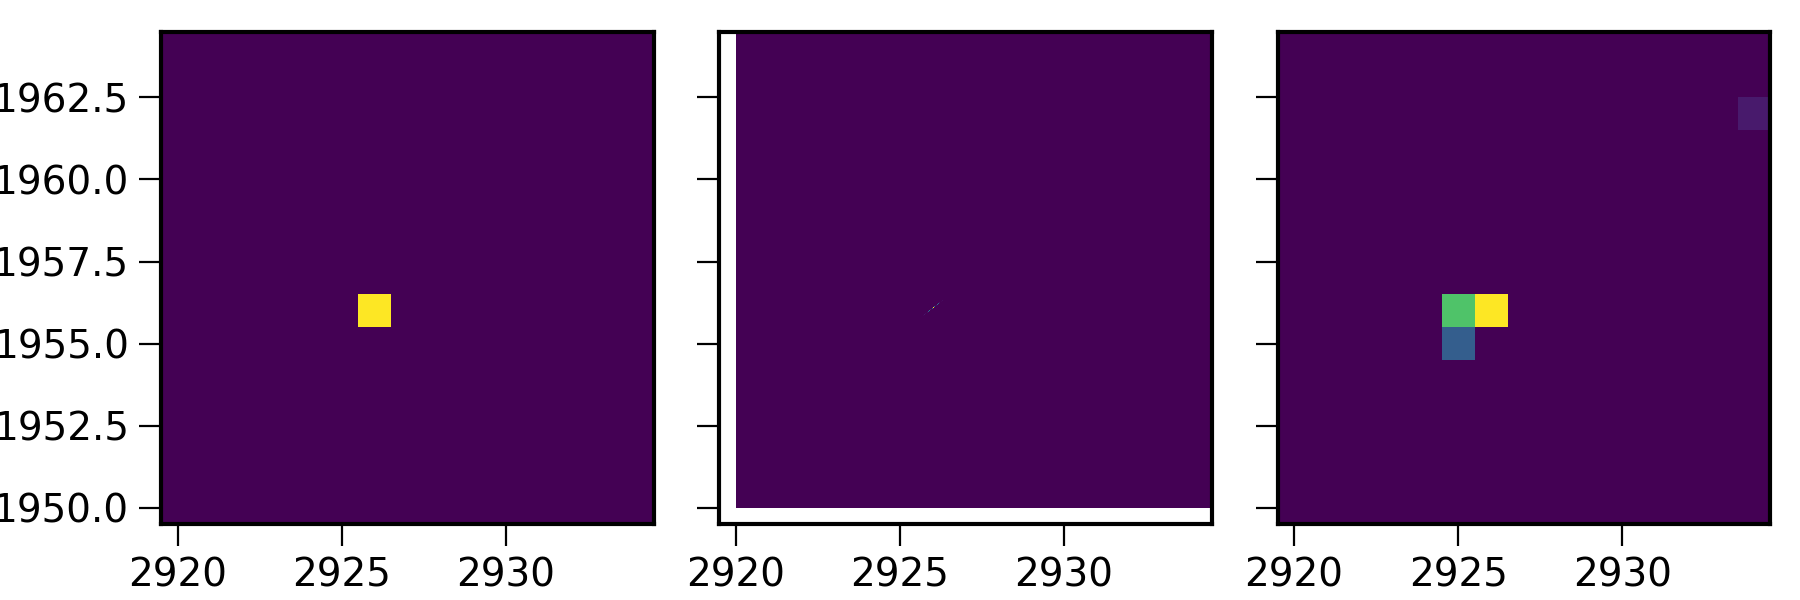

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(9,3), sharex=True, sharey=True)
ax[0].imshow(gss_crop,  extent=extent_crop)
ax[1].imshow(gss_hires, extent=extent_hires)
ax[2].imshow(gss_rebin, extent=extent_crop)

In [17]:
# This line after plot often skipped when stepping through

In [18]:
flux_lensed = gss_rebin.sum()
flux_source = 2 * np.pi * amplitude * sigma**2
flux_lensed / flux_source  # magnification

61.29696651597327

# Summary of input size

In [19]:
sigma  # pixels

0.003

In [20]:
radius = sigma * 0.06 * u.arcsec  # pixels -> arcsec
radius

<Quantity 0.00018 arcsec>

In [21]:
1 / cosmo.arcsec_per_kpc_proper(zs_out)

<Quantity 5.60856953 kpc / arcsec>

In [22]:
radius = radius / cosmo.arcsec_per_kpc_proper(zs_out)
radius.to(u.pc)

<Quantity 1.00954252 pc>

In [23]:
2 * 0.06 * u.arcsec / cosmo.arcsec_per_kpc_proper(zs_out)

<Quantity 0.67302834 kpc>

In [24]:
#DA = cosmo.angular_diameter_distance_z1z2(0 , zs_out).value * 10**6 #returns in pc
DA = cosmo.angular_diameter_distance_z1z2(0 , zs_out)
DA

<Quantity 1156.85050773 Mpc>